# Question 4
### Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

In [16]:
from matplotlib import cm
import matplotlib.colors
# Create custom color mapping to match the paper
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkblue","blue","cyan","white","yellow","red","darkred"])

In [4]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [5]:
temp = ds.analysed_sst

In [6]:
#2002-2012 Data
temp_2002_2012 = temp.sel(time = slice("2002","2012"))

In [7]:
#2002-2012 mean grouped by month
temp_mean_2002_2012 = temp_2002_2012.groupby('time.month').mean('time')

In [8]:
#2002-2012 sd grouped by month
temp_SD_2002_2012 = temp_2002_2012.groupby('time.month').std('time')

In [9]:
#2014-2016 Data
temp_2014_2016 = temp.sel(time = slice("2014","2016"))

In [10]:
#2014-2016 monthly mean
temp_monthly_mean_2014_2016 = temp_2014_2016.resample(time='M').mean()

In [11]:
#anomaly_2014
anomaly_2014 = []
for month_2014, month in zip(range(0,12), range(0,12)):
        anomaly_per_month_2014 = temp_monthly_mean_2014_2016[month_2014] - temp_mean_2002_2012[month]
        anomaly_2014.append(anomaly_per_month_2014)
        anomalies_2014 = xr.concat(anomaly_2014, dim='month')

In [12]:
#anomaly_2015
anomaly_2015 = []
for month_2015, month in zip(range(12,24), range(0,12)):
        anomaly_per_month_2015 = temp_monthly_mean_2014_2016[month_2015] - temp_mean_2002_2012[month]
        anomaly_2015.append(anomaly_per_month_2015)
        anomalies_2015 = xr.concat(anomaly_2015, dim='month')

In [13]:
#anomaly_2016
anomaly_2016 = []
for month_2016, month in zip(range(24,36), range(0,12)):
        anomaly_per_month_2016 = temp_monthly_mean_2014_2016[month_2016] - temp_mean_2002_2012[month]
        anomaly_2016.append(anomaly_per_month_2016)
        anomalies_2016 = xr.concat(anomaly_2016, dim='month')

In [14]:
# Make any value that lies within +- 1 delta SST SD to be 0
# Do this by masking and then filling with 0
anomalies_2014_mask = anomalies_2014.where((anomalies_2014 < -1) | (anomalies_2014 > 1))
anomalies_2015_mask = anomalies_2015.where((anomalies_2015 < -1) | (anomalies_2015 > 1))
anomalies_2016_mask = anomalies_2016.where((anomalies_2016 < -1) | (anomalies_2016 > 1))
# Fill with 0's, these will be used in our final plot!
anomalies_2014_white = anomalies_2014_mask.fillna(0)
anomalies_2015_white = anomalies_2015_mask.fillna(0)
anomalies_2016_white = anomalies_2016_mask.fillna(0)

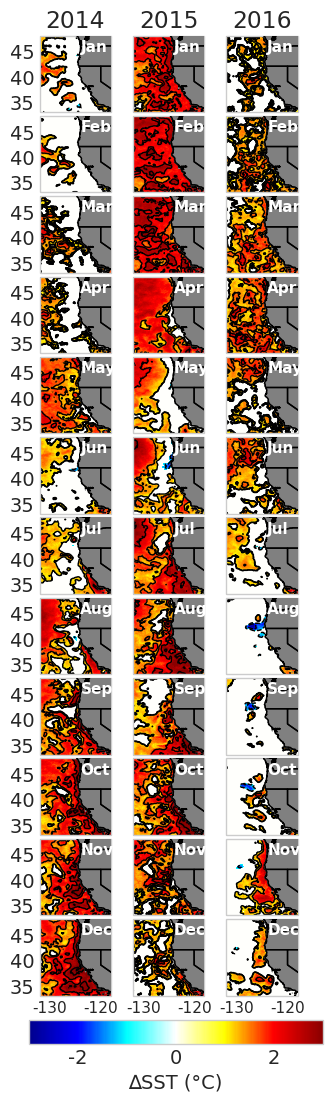

In [17]:
# Composing the entire plot for all months and years included
n_months=12
n_years=3
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
years = ["2014","2015","2016"]
fig, axs = plt.subplots(nrows=n_months, ncols=n_years, sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(7,24))


# loop through the months and plots
for i in range(n_months):
    for j in range(n_years):    
        # Choose correct dataset to plot by per year
        if j == 0:
            # j = 0 corresponds to 2014
            anomalies = anomalies_2014_white
        if j == 1:
            # j = 0 corresponds to 2015
            anomalies = anomalies_2015_white
        if j == 2:
            # j = 0 corresponds to 2016
            anomalies = anomalies_2016_white
            
        # Plot the anomalies
        overall_plot = anomalies[i,:,:].plot(ax=axs[i, j], transform=crs, cmap=cmap_custom,add_colorbar=False,vmin=-3, vmax=3,zorder=1) 
        anomalies[i,:,:].plot.contour(ax=axs[i, j], colors='black', linewidths=1,zorder=2)
        axs[i,j].add_feature(cfeature.LAND, color="grey",zorder=3)
        axs[i,j].add_feature(cfeature.STATES.with_scale("10m"),zorder=4)
        # Remove default title
        axs[i,j].set_title("")
        # Remove default labels
        axs[i,j].set(xlabel=None, ylabel=None)
        # Plot month name
        axs[i,j].text(-124, 45, months[i], fontsize=11, color="white", fontweight="semibold",zorder=5)

        # Plot overall titles for the figure
        if i == 0:
            # First row add year
            axs[i,j].set_title(years[j])
        if j == 0:
            # Left col add yticks for lat
            axs[i,j].set_yticks([35, 40, 45])
        if i == 11:
            # Bottom row add xticks for long
            axs[i,j].set_xticks([-130, -120])
            axs[i,j].set_xticklabels([-130, -120], fontsize=11)  

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.5,top=0.5,wspace=0.0025,hspace=0.05)      

# Plotting legend
# Try to put the ax in the right place
ax = fig.add_axes([.10, .08, .42, .01])
# Plot the colorbar
cbar = plt.colorbar(overall_plot, cax=ax, orientation='horizontal')
cbar.set_label('∆SST (°C)', loc="center")
cbar.set_ticks([-2, 0, 2])
cbar.set_ticklabels([-2, 0, 2])

fig.show()